## Work
1. 請比較 SGD optimizer 不同的 momentum 及使用 nesterov 與否的表現

In [ ]:
import os
import keras
from keras.datasets import cifar10
# 本作業可以不需使用 GPU, 將 GPU 設定為 "無" (若想使用可自行開啟)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
train, test = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step


In [ ]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [ ]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [ ]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
  input_layer = keras.layers.Input(input_shape)

  for i, n_units in enumerate(num_neurons):
      if i == 0:
          x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
      else:
          x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)

  out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)

  model = keras.models.Model(inputs=[input_layer], outputs=[out])
  return model

In [ ]:
"""Code Here
設定超參數
"""
# 超參數設定
LEARNING_RATE = [1e-3]
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = [0.5, 0.75, 0.95]
NESTEROV = [True, False]

In [ ]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
import itertools
for lr, momentum, nesterov in itertools.product(LEARNING_RATE, MOMENTUM, NESTEROV):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with LR = %.3f, Momentum = %.2f, Nesterov = %s" % (lr, momentum, str(nesterov)))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=lr, nesterov=nesterov, momentum=momentum)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-lr-%s-momemtum-%s-nesterov-%s" % (str(lr), str(momentum), str(nesterov))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with LR = 0.001, Momentum = 0.50, Nesterov = True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 hidden_layer3 (Dense)       (None, 128)               32896     
                                                                 
 output (Dense)              (None, 10)                1290      
                                                                 
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
________________________________________________________

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
196/196 [==============================] - 13s 58ms/step - loss: 2.2395 - accuracy: 0.1816 - val_loss: 2.1722 - val_accuracy: 0.2212
Epoch 2/50
196/196 [==============================] - 21s 110ms/step - loss: 2.1286 - accuracy: 0.2455 - val_loss: 2.0899 - val_accuracy: 0.2620
Epoch 3/50
196/196 [==============================] - 11s 55ms/step - loss: 2.0541 - accuracy: 0.2784 - val_loss: 2.0232 - val_accuracy: 0.2935
Epoch 4/50
196/196 [==============================] - 10s 51ms/step - loss: 1.9961 - accuracy: 0.3013 - val_loss: 1.9744 - val_accuracy: 0.3128
Epoch 5/50
196/196 [==============================] - 10s 53ms/step - loss: 1.9516 - accuracy: 0.3197 - val_loss: 1.9349 - val_accuracy: 0.3239
Epoch 6/50
196/196 [==============================] - 10s 52ms/step - loss: 1.9160 - accuracy: 0.3318 - val_loss: 1.9023 - val_accuracy: 0.3319
Epoch 7/50
196/196 [==============================] - 9s 46ms/step - loss: 1.8875 - accuracy: 0.3410 - val_loss: 1.8774 - val_accuracy:

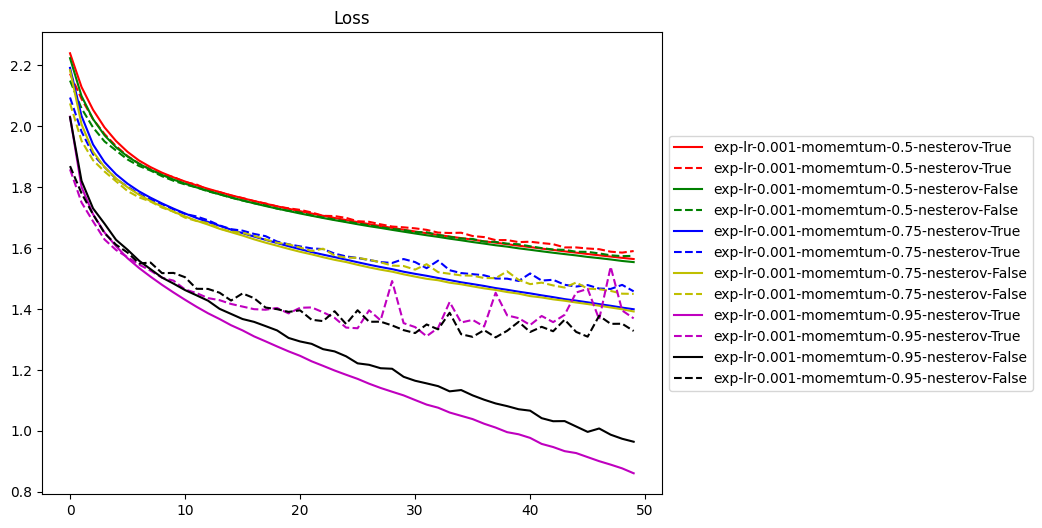

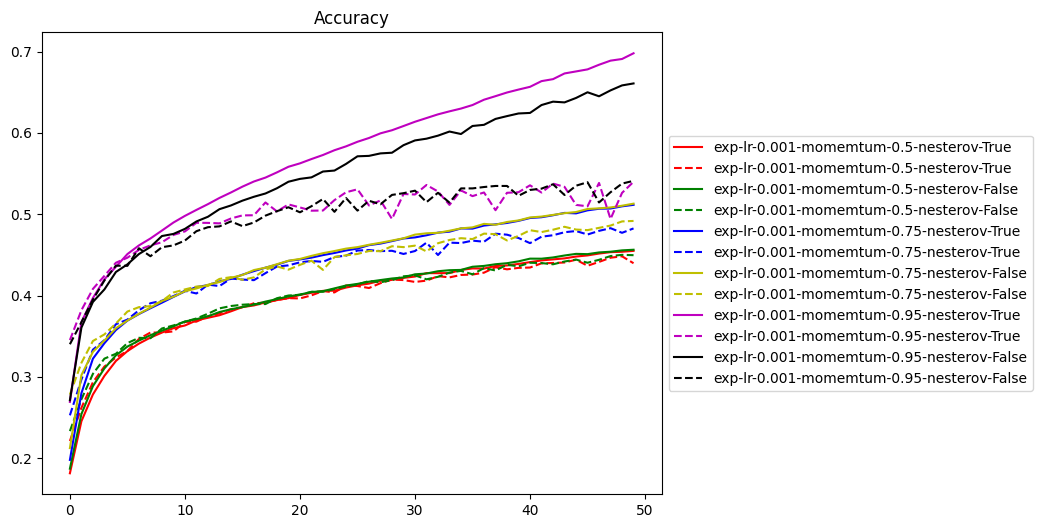

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()